# Q-learning

- Init `Q`
- Repeat an episode
  - For each step:
    - get an action from the policy(`Q`, `epsilon`)
    - go one step and get a next state and the reward
    - udpate `Q` with Q learning algorithm
  - The current episode ends when the environment said it's done.

In [1]:
%matplotlib inline
import math
from IPython.display import display, HTML
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.lines as lines
from matplotlib import animation
from scipy.special import softmax
import gym

In [2]:
np.random.seed(0)

In [3]:
# force = -1 or 1

# x, x_dot, theta, theta_dot = observation
# -2.4 <= x <= 2.4
# -inf < x_dot < inf
# -12º <= theta <= 12º
# -inf < theta_dot < inf

N_FEATURES = 4
N_INTERVALS_PER_FEATURE = 6
N_PIVOTS = N_INTERVALS_PER_FEATURE - 1
N = N_INTERVALS_PER_FEATURE ** N_FEATURES

def digitize(_min, _max, n_intervals=N_INTERVALS_PER_FEATURE):
    return np.linspace(_min, _max, n_intervals+1)[1:-1]

PIVOTS = [
    digitize(-2.4, 2.4),
    digitize(-3, 3),
    digitize(-0.5, 0.5),
    digitize(-2, 2),
]

def observations2state(observation):
    """digitize observation to a state"""
    feature_indices = [np.sum(PIVOTS[idx] < val) for idx, val in enumerate(observation)]
    
    return np.sum(
        [
            feature_indices[i] * N_INTERVALS_PER_FEATURE**(i)
            for i
            in range(N_FEATURES)
        ]
    )

N_ACTIONS = 2
print(f"N={N}")

def action2force(action):
    return action

N=1296


In [4]:
uniform_q = np.ones((N,N_ACTIONS))
initial_q = np.random.rand(N, N_ACTIONS) * uniform_q

In [5]:
def plot_rewards(scores, epsilons):
    plt.plot(
        tuple(range(len(scores))),
        tuple(h for h in scores)
    )
    plt.draw()
    plt.show()

    plt.plot(
        tuple(range(len(epsilons))),
        tuple(h for h in epsilons)
    )
    plt.draw()
    plt.show()

def get_action(q, state, epsilon):
    if np.random.rand() < epsilon:
        ret = np.random.choice(N_ACTIONS)
    else:
        ret = np.argmax(q[state,:])
    return ret

def run(q, epsilon, env):
    observation = env.reset()
    state = observations2state(observation)

    for i in range(1000):
        action = get_action(q, state, epsilon)

        next_observation, reward, done, info = env.step(action2force(action))
        next_state = observations2state(next_observation)

        q = get_updated_q(state, action, reward, next_state, done, q)
            
        if done:
            return q, i
        else:
            state = next_state
    
    raise Exception("Infinite loop encountered!")

def get_updated_q(state, action, reward, next_state, done, q, eta=0.1, gamma=0.9):
    q_updated = q.copy()
    
    if done:
        q[state, action] = q[state, action] + eta * (reward - q[state, action])
    else:
        q[state, action] = q[state, action] + eta * (reward + gamma*np.max(q[next_state, :]) - q[state, action])

    return q

def train(q, init_epsilon = 0.5, target_epsilon = 0.001, n_iterations = 20000):
    assert target_epsilon <= init_epsilon
    epsilon = init_epsilon

    env = gym.make('CartPole-v1')
    
    all_rewards = []
    all_epsilons = []
    
    avg_window = 50
    avg_rewards = []
    avg_epsilons = []
    
    decay = math.e ** (math.log(target_epsilon/epsilon) / (n_iterations - 1))

    for i in range(n_iterations):
        q, reward = run(q, epsilon, env)
        all_rewards.append(reward)
        all_epsilons.append(epsilon)
        
        epsilon *= decay

        if len(all_rewards) >= avg_window:
            avg_reward = np.average(all_rewards[i-avg_window+1:i+1])
            avg_epsilon = np.average(all_epsilons[i-avg_window+1:i+1])
            
            if avg_reward > 490 and epsilon < 0.05:
                break
            
            avg_rewards.append(avg_reward)
            avg_epsilons.append(avg_epsilon)
            
            if i % 1000 == 0:
                print(i, avg_reward, avg_epsilon)
    
    print(i, avg_reward, avg_epsilon)
    print(f"epsilon={epsilon}")
    print(f"q={q}")
    
    env.close()

    return q, all_rewards, avg_rewards, avg_epsilons

1000 85.68 0.3692542703947553
2000 141.16 0.27062647367074655
3000 155.9 0.19834215640395025
4000 179.0 0.14536497657960504
5000 183.16 0.10653799877497093
6000 192.94 0.07808170475479007
7000 196.52 0.05722608541100659
8000 191.18 0.04194100092655724
9000 169.74 0.03073856172561394
10000 197.34 0.022528293461901803
11000 202.72 0.01651098743122567
12000 191.06 0.012100903533377476
13000 225.54 0.008868752818936477
14000 191.38 0.006499909394901198
15000 168.24 0.0047637839281884
16000 306.46 0.0034913774847796925
17000 255.62 0.002558830737283703
18000 219.76 0.0018753671783161595
19000 247.54 0.0013744567009691894
19999 154.76 0.0010076524617527016
epsilon=0.0009996893023352328
q=[[0.5488135  0.71518937]
 [0.60276338 0.54488318]
 [0.4236548  0.64589411]
 ...
 [0.32290711 0.34574585]
 [0.40051046 0.41091573]
 [0.10325322 0.51909894]]


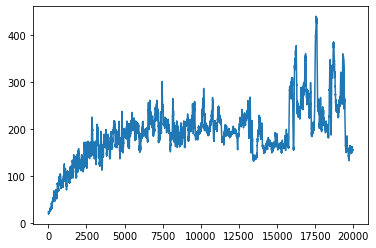

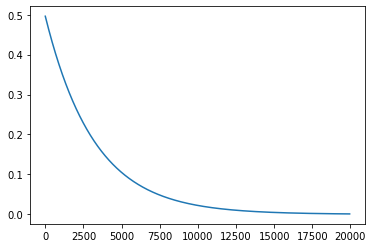

In [6]:
q, all_rewards, avg_rewards, avg_epsilons = train(initial_q)
plot_rewards(avg_rewards, avg_epsilons)

In [7]:
def display_frames_as_video(frames):
    fig = plt.figure(figsize=(frames[0].shape[1]/72.0, frames[0].shape[0]/72.0), dpi=72)
    plt.axis('off')
    
    ims = []
    for i, frame in enumerate(frames):
        im = plt.imshow(frame, animated=True)
        ims.append([im])
        
    anim = animation.ArtistAnimation(fig, ims, interval=40, blit=True, repeat=False)
    display(HTML(anim.to_html5_video()))
    plt.close()

def test(q):
    env = gym.make('CartPole-v1')
    env._max_episode_steps = 1000
    observation = env.reset()
    state = observations2state(observation)
    
    frames = []

    for i in range(1000):
        frame = env.render(mode="rgb_array")
        frames.append(frame)
        action = get_action(q, state, 0)
        observation, reward, done, info = env.step(action2force(action)) # take a random action
        if done:
            print(i)
            break
        else:
            state = observations2state(observation)
    env.close()
    display_frames_as_video(frames)
    
test(q)

214


In [8]:
# q, all_rewards, avg_rewards, avg_epsilons = train(q, init_epsilon=0.001, target_epsilon=0.001, n_iterations=5000)
# plot_rewards(avg_rewards, avg_epsilons)
# test(q)